In [1]:
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

!pip3 install -Uv nle

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [44.8 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,131 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,400 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,009 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Hit:13 https://ppa.l

In [2]:
!pip install minihack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for minihack: filename=minihack-0.1.5-py3-none-any.whl size=265154 sha256=3d99a4bcfcb4480fbc4a19c269203fc8798d7db94479218fe9cc436588ad4f22
  Stored in directory: /root/.cache/pip/wheels/ae/63/66/5cff213ff21473ce5e15028cb185f16f79f37fff557dfc8eef
Successfully built minihack


In [3]:
import torch
import gym
import numpy as np

import torch.optim as op
import torch.nn.functional as torch_func

import matplotlib.pyplot as plt
import pandas as pd
import minihack
from minihack import RewardManager
from nle import nethack
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# hyperparameters
hidden_size = 256
learning_rate = 0.0002

# Constants
GAMMA = 0.99
num_steps = 5000
max_episodes = 100

PICTURE_HEIGHT = 21
PICTURE_WIDTH = 79
PICTURE_CHANNELS = 1


ACTION_SPACE = [
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
      nethack.CompassDirection.NE,
      nethack.CompassDirection.SE,
      nethack.CompassDirection.SW,
      nethack.CompassDirection.NW,
      nethack.CompassDirectionLonger.N,
      nethack.CompassDirectionLonger.E,
      nethack.CompassDirectionLonger.S,
      nethack.CompassDirectionLonger.W,
      nethack.CompassDirectionLonger.NE,
      nethack.CompassDirectionLonger.SE,
      nethack.CompassDirectionLonger.SW,
      nethack.CompassDirectionLonger.NW,
      nethack.Command.EAT,
      nethack.MiscDirection.DOWN,
      nethack.MiscDirection.WAIT,
      nethack.MiscAction.MORE,
      nethack.Command.ADJUST,
      nethack.Command.APPLY,
      nethack.Command.ATTRIBUTES,
      nethack.Command.CALL,
      nethack.Command.CAST,
      nethack.Command.CHAT,
      nethack.Command.CLOSE,
      nethack.Command.DIP,
      nethack.Command.DROP,
      nethack.Command.DROPTYPE,
      nethack.Command.ENGRAVE,
      nethack.Command.ENHANCE,
      nethack.Command.ESC,
      nethack.Command.FIGHT,
      nethack.Command.FIRE,
      nethack.Command.FORCE,
      nethack.Command.INVENTORY,
      nethack.Command.INVENTTYPE,
      nethack.Command.INVOKE,
      nethack.Command.JUMP,
      nethack.Command.KICK,
      nethack.Command.LOOK,
      nethack.Command.LOOT,
      nethack.Command.MONSTER,
      nethack.Command.MOVE,
      nethack.Command.MOVEFAR,
      nethack.Command.OFFER,
      nethack.Command.OPEN,
      nethack.Command.PAY,
      nethack.Command.PICKUP,
      nethack.Command.PRAY,
      nethack.Command.PUTON,
      nethack.Command.QUAFF,
      nethack.Command.QUIVER,
      nethack.Command.READ,
      nethack.Command.REMOVE,
      nethack.Command.RIDE,
      nethack.Command.RUB,
      nethack.Command.RUSH,
      nethack.Command.RUSH2,
      nethack.Command.SEARCH,
      nethack.Command.SEEARMOR,
      nethack.Command.SEERINGS,
      nethack.Command.SEETOOLS,
      nethack.Command.SEETRAP,
      nethack.Command.SEEWEAPON,
      nethack.Command.SHELL,
      nethack.Command.SIT,
      nethack.Command.SWAP,
      nethack.Command.TAKEOFF,
      nethack.Command.TAKEOFFALL,
      nethack.Command.THROW,
      nethack.Command.TIP,
      nethack.Command.TURN,
      nethack.Command.TWOWEAPON,
      nethack.Command.UNTRAP,
      nethack.Command.VERSIONSHORT,
      nethack.Command.WEAR,
      nethack.Command.WIELD,
      nethack.Command.WIPE,
      nethack.Command.ZAP,
      nethack.TextCharacters.PLUS,
      nethack.TextCharacters.QUOTE,
      nethack.TextCharacters.DOLLAR,
      nethack.TextCharacters.SPACE,
]

MOVE_ACTION_SPACE = [
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
      nethack.CompassDirection.NE,
      nethack.CompassDirection.SE,
      nethack.CompassDirection.SW,
      nethack.CompassDirection.NW,
      nethack.CompassDirectionLonger.N,
      nethack.CompassDirectionLonger.E,
      nethack.CompassDirectionLonger.S,
      nethack.CompassDirectionLonger.W,
      nethack.CompassDirectionLonger.NE,
      nethack.CompassDirectionLonger.SE,
      nethack.CompassDirectionLonger.SW,
]


EAT_ACTION_SPACE = [
      nethack.CompassDirection.N,
      nethack.CompassDirection.E,
      nethack.CompassDirection.S,
      nethack.CompassDirection.W,
      nethack.CompassDirection.NE,
      nethack.CompassDirection.SE,
      nethack.CompassDirection.SW,
      nethack.CompassDirection.NW,
      nethack.CompassDirectionLonger.N,
      nethack.CompassDirectionLonger.E,
      nethack.CompassDirectionLonger.S,
      nethack.CompassDirectionLonger.W,
      nethack.CompassDirectionLonger.NE,
      nethack.CompassDirectionLonger.SE,
      nethack.CompassDirectionLonger.SW,
      nethack.Command.EAT,
]

device = torch.device("cpu")

In [8]:
reward_manager = RewardManager()

EAT_ITEMS = [
    "apple",
    "orange",
    "meatball",
    "meat ring",
    "meat stick",
    "kelp frond",
    "eucalyptus leaf",
    "clove of garlic",
    "sprig of wolfsbane",
    "carrot",
    "egg",
    "banana",
    "melon",
    "candy bar",
    "lump of royal jelly",
]

MONSTERS = [
    "jackal",
    "rat",
    "lichen"
]

WIELDED_ITEMS = [
    "dagger",
    "staff",
]

for eat in EAT_ITEMS:
  reward_manager.add_eat_event(name=eat, reward=0.1)

for monster in MONSTERS:
  reward_manager.add_kill_event(name=monster, reward=0.1)

for wield in WIELDED_ITEMS:
  reward_manager.add_wield_event(name=wield, reward=0.1)


In [47]:

envs = [
    {"name": "MiniHack-Room-Random-5x5-v0", "episodes": 50, "action_space": MOVE_ACTION_SPACE, "must_print": False},
    {"name": "MiniHack-Eat-v0", "episodes": 300, "action_space": EAT_ACTION_SPACE, "must_print": False},
    {"name": "MiniHack-LavaCross-Full-v0", "episodes": 250, "action_space": ACTION_SPACE, "must_print": False},
]

quest_envs = [
    {"name": "MiniHack-Quest-Hard-v0", "episodes": 500, "action_space": ACTION_SPACE, "must_print": False},
]

In [14]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work.
        Expects inputs to be of shape height x width x num_channels
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = PICTURE_WIDTH
        self.height = PICTURE_HEIGHT
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(self.height, self.width, 1), dtype=np.uint8
        )

    def observation(self, frame):
        frame = frame["pixel"]
        # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self.width, self.height), interpolation=cv2.INTER_AREA
        )
        return frame[:, :, None]


class GlyphWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        glyphs = observation["glyphs"]
        glyphs_tensor = torch.tensor(glyphs, dtype=torch.float32)
        flattened = glyphs_tensor.view(glyphs_tensor.size(0)*glyphs_tensor.size(1))
        flattened = torch.div(flattened, other=torch.max(flattened))

        return flattened.unsqueeze(0)

class Glyp2DhWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        glyphs = observation["glyphs"]
        glyphs_tensor = torch.tensor(glyphs, dtype=torch.float32)
        glyphs_tensor = torch.div(glyphs_tensor, other=torch.max(glyphs_tensor))

        glyphs_cropped = observation["glyphs_crop"]
        glyphs_cropped_tensor = torch.tensor(glyphs_cropped, dtype=torch.float32)
        glyphs_cropped_tensor = torch.div(glyphs_cropped_tensor, other=torch.max(glyphs_cropped_tensor))

        message = observation["message"]
        message_tensor = torch.tensor(message, dtype=torch.float32)
        message_tensor = torch.div(message_tensor, other=torch.max(message_tensor)) if torch.max(message_tensor) != 0 else message_tensor

        state ={
            "glyphs": glyphs_tensor.unsqueeze(0).unsqueeze(0),
            "glyphs_cropped": glyphs_cropped_tensor.unsqueeze(0).unsqueeze(0),
            "message": message_tensor.unsqueeze(0)
        }

        return state

In [28]:
class ActorCriticModel2D(torch.nn.Module):
    def __init__(self, action_space):
        super(ActorCriticModel2D, self).__init__()

        self.action_space = action_space

        # Activations
        self.relu_layer = torch.nn.ReLU()
        self.max_pooling = torch.nn.MaxPool2d(kernel_size=3)
        self.tanh_layer = torch.nn.Tanh()

        # Convolutional layers BIG
        self.cnn_layer_one = torch.nn.Conv2d(in_channels=PICTURE_CHANNELS, stride=1, kernel_size=(3, 3),
                                             out_channels=32)
        self.cnn_layer_two = torch.nn.Conv2d(in_channels=32, stride=1, kernel_size=(3, 3),
                                             out_channels=64)
        self.cnn_layer_three = torch.nn.Conv2d(in_channels=64, stride=1, kernel_size=(3, 3),
                                               out_channels=64)

        # Convolutional layers CROPPED
        self.cnn_layer_one_crop = torch.nn.Conv2d(in_channels=PICTURE_CHANNELS, stride=1, kernel_size=(3, 3),
                                             out_channels=8)
        self.cnn_layer_two_crop = torch.nn.Conv2d(in_channels=8, stride=1, kernel_size=(3, 3),
                                             out_channels=16)
        self.cnn_layer_three_crop = torch.nn.Conv2d(in_channels=16, stride=1, kernel_size=(3, 3),
                                               out_channels=32)

        # Message layers
        self.message_input = torch.nn.Linear(in_features=256, out_features=1000)
        self.message_hidden = torch.nn.Linear(in_features=1000, out_features=512)
        self.message_output = torch.nn.Linear(in_features=512, out_features=100)

        # Dummy input for flattened input
        dummy_input = torch.zeros(1, PICTURE_CHANNELS, PICTURE_WIDTH, PICTURE_HEIGHT)
        conv_out = self.forward_conv(dummy_input)
        conv_out = conv_out.view(conv_out.size(0), -1)
        # conv_out_shape = int(np.prod(conv_out.shape))
        dummy_message = torch.zeros((1, 256))
        dummy_message = self.message_forward(dummy_message)
        dummy_glyph_cropped = torch.zeros(1, PICTURE_CHANNELS, 9, 9)
        cropped_conv_out = self.forward_conv_crop(dummy_glyph_cropped)
        cropped_conv_out = cropped_conv_out.view(cropped_conv_out.size(0), -1)
        # cropped_conv_out_shape = int(np.prod(conv_out.shape))

        dummy_output = torch.cat(tensors=(conv_out, cropped_conv_out, dummy_message), dim=1)
        dummy_output_shape = int(np.prod(dummy_output.shape))

        # Critic layers
        self.critic_input = torch.nn.Linear(in_features=dummy_output_shape, out_features=1000)
        self.critic_hidden = torch.nn.Linear(in_features=1000, out_features=512)
        self.critic_final = torch.nn.Linear(in_features=512, out_features=self.action_space)

        # Actor layers
        self.actor_input = torch.nn.Linear(in_features=dummy_output_shape, out_features=1000)
        self.actor_hidden = torch.nn.Linear(in_features=1000, out_features=512)
        self.actor_final = torch.nn.Linear(in_features=512, out_features=self.action_space)

    def forward_conv(self, state):
        state = self.relu_layer(self.cnn_layer_one(state))
        # state = self.max_pooling(state)
        state = self.relu_layer(self.cnn_layer_two(state))
        # state = self.max_pooling(state)
        state = self.relu_layer(self.cnn_layer_three(state))
        state = self.max_pooling(state)
        return state

    def forward_conv_crop(self, state):
        state = self.relu_layer(self.cnn_layer_one_crop(state))
        # state = self.max_pooling(state)
        state = self.relu_layer(self.cnn_layer_two_crop(state))
        # state = self.max_pooling(state)
        state = self.relu_layer(self.cnn_layer_three_crop(state))
        state = self.max_pooling(state)
        return state

    def actor_forward(self, state):
        actor_input = self.actor_input(state)
        actor_input = self.tanh_layer(actor_input)
        actor_hidden = self.actor_hidden(actor_input)
        actor_hidden = self.relu_layer(actor_hidden)
        policy_dist = self.actor_final(actor_hidden)
        policy_softmax_dist = torch_func.softmax(policy_dist)

        return policy_softmax_dist

    def critic_forward(self, state):
        critic_input = self.critic_input(state)
        critic_input = self.tanh_layer(critic_input)
        critic_hidden = self.critic_hidden(critic_input)
        critic_hidden = self.relu_layer(critic_hidden)
        value = self.critic_final(critic_hidden)

        return value

    def message_forward(self, state):
        message_input = self.message_input(state)
        message_input = self.tanh_layer(message_input)
        message_hidden = self.message_hidden(message_input)
        message_hidden = self.tanh_layer(message_hidden)
        message_output = self.message_output(message_hidden)

        return message_output

    def forward(self, state):
        # Glyph
        glyphs = state["glyphs"]
        conv_state = self.forward_conv(state=glyphs)
        feature_extraction = conv_state.view(conv_state.size(0), -1)

        # Cropped glyph
        glyphs_cropped = state["glyphs_cropped"]
        cropped_conv_state = self.forward_conv_crop(state=glyphs_cropped)
        cropped_feature_extraction = cropped_conv_state.view(cropped_conv_state.size(0), -1)

        # Message state
        message_state = self.message_forward(state["message"])

        output_state = torch.cat(tensors=(feature_extraction, message_state, cropped_feature_extraction), dim=1)

        # Actor
        policy_softmax_dist = self.actor_forward(output_state)

        # Critic
        value = self.critic_forward(output_state)

        # value = value.cuda()
        # policy_softmax_dist = policy_softmax_dist.cuda()

        return policy_softmax_dist, value

    # def set_action_space(self, length):
    #     self.action_space_length = len(length)


In [33]:
class ActorCriticModel(torch.nn.Module):
    def __init__(self):
        super(ActorCriticModel, self).__init__()

        self.action_space = 2

        self.critic_input = torch.nn.Linear(in_features=1659, out_features=1000)
        self.critic_hidden = torch.nn.Linear(in_features=1000, out_features=512)
        self.critic_final = torch.nn.Linear(in_features=512, out_features=self.action_space)

        self.actor_input = torch.nn.Linear(in_features=1659, out_features=1000)
        self.actor_hidden = torch.nn.Linear(in_features=1000, out_features=512)
        self.actor_final = torch.nn.Linear(in_features=512, out_features=self.action_space)

        self.relu_layer = torch.nn.ReLU()
        self.tanh_layer = torch.nn.Tanh()

    def set_action_space(self, env):
        self.action_space = env.action_space.n
        self.critic_final = torch.nn.Linear(in_features=512, out_features=self.action_space)
        self.actor_final = torch.nn.Linear(in_features=512, out_features=self.action_space)


    def forward(self, state):
        # Actor
        actor_input = self.actor_input(state)
        actor_input = self.tanh_layer(actor_input)
        actor_hidden = self.actor_hidden(actor_input)
        actor_hidden = self.relu_layer(actor_hidden)
        policy_dist = self.actor_final(actor_hidden)
        policy_softmax_dist = torch_func.softmax(policy_dist)

        # Critic
        critic_input = self.critic_input(state)
        critic_input = self.tanh_layer(critic_input)
        critic_hidden = self.critic_hidden(critic_input)
        critic_hidden = self.relu_layer(critic_hidden)
        value = self.critic_final(critic_hidden)

        # value = value.cuda()
        # policy_softmax_dist = policy_softmax_dist.cuda()

        return policy_softmax_dist, value



In [45]:
class ActorCriticRun():
    def __init__(self, action_space, env_name, model, env, max_episodes, must_print=False):
        self.env = env
        self.A2C_model = model

        self.all_lengths = []
        self.average_lengths = []
        self.all_rewards = []
        self.entropy_term = 0
        self.optimizer = op.Adam(self.A2C_model.parameters(), lr=learning_rate)
        self.action_space = action_space
        self.must_print = must_print
        self.max_episodes = max_episodes
        self.env_name = env_name

    def run(self):

        for ep in range(self.max_episodes):
            log_probs = []
            values = []
            rewards = []

            state = self.env.reset()
            for step in range(num_steps):
                policy_dist, value = self.A2C_model(state)
                value = value.cpu().detach().numpy()[0,0]
                dist = policy_dist.cpu().detach().numpy() 
                sum_dist = list(map(lambda x: (x/np.sum(dist[0][0:len(self.action_space)])), dist[0][0:len(self.action_space)])) if np.max(dist[0][0:len(self.action_space)]) != 0 else dist[0][0:len(self.action_space)]
                action = np.random.choice(self.env.action_space.n, p=np.squeeze(sum_dist))
                if self.must_print:
                  print(sum_dist)
                  print(f"{action=}")

                log_prob = torch.log(policy_dist.squeeze(0)[action])
                entropy = -np.sum(np.mean(dist)*np.log(dist)) 
                next_state, reward, terminated, info = self.env.step(action)

                rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)
                self.entropy_term += entropy
                state = next_state

                if terminated or step == num_steps-1:
                    _, Qval = self.A2C_model(next_state)
                    Qval = torch.max(Qval.squeeze()) 
                    self.all_rewards.append(np.sum(rewards))
                    self.all_lengths.append(step+1)
                    self.average_lengths.append(np.mean(self.all_lengths[-10:]))
                    if ep % 1 == 0:
                        print(f"episode: {ep+1}, reward: {np.sum(rewards)}, average_reward: {np.mean(self.all_rewards)} total length: {step+1}, average length: {self.average_lengths[-1]}")

                    break

            Qvals = np.zeros_like(values) 
            for t in reversed(range(len(rewards))):
                Qval = rewards[t] + GAMMA * Qval
                Qvals[t] = Qval

            values = torch.FloatTensor(values)
            Qvals = torch.FloatTensor(Qvals)
            log_probs = torch.stack(log_probs).cpu()

            advantage = Qvals - values
            actor_loss = (-log_probs*advantage).mean()  
            critic_loss = 0.5 * advantage.pow(2).mean()  
            ac_loss = actor_loss + critic_loss + 0.001 * self.entropy_term  

            self.optimizer.zero_grad()
            ac_loss.backward()
            self.optimizer.step()


    def plot_results(self):
      plt.plot(self.all_rewards, label="All Rewards")
      plt.plot()
      plt.xlabel("Episode")
      plt.ylabel("Reward")
      plt.title(self.env_name)
      plt.legend()
      plt.show()

      plt.plot(self.all_lengths, label="All lengths")
      plt.plot(self.average_lengths, label="Avg lengths")
      plt.xlabel("Episode")
      plt.ylabel("Episode Length")
      plt.title(self.env_name)
      plt.legend()
      plt.show()

In [74]:
agent = ActorCriticModel()

for env in envs:
  print(f"{'-'*5} Starting {env} {'-'*5} ")

  env = gym.make(env, actions=ACTION_SPACE, observation_keys=("glyphs", "chars", "colors", "pixel", "message"), reward_manager=reward_manager)
  # self.env = WarpFrame(self.env)
  env = GlyphWrapper(env)

  agent.set_action_space(env)
  a2c = ActorCriticRun(action_space=ACTION_SPACE, env_name=env, model=agent, env=env)
  a2c.run()
  a2c.plot_results()

  torch.save(agent.state_dict(), "/content/drive/MyDrive/University/Honours/RLWeights/a2c_cnn_weights.pth")

NameError: ignored

----- Starting MiniHack-Room-Random-5x5-v0 ----- 


<ipython-input-28-dfb5483ff5ae>:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_softmax_dist = torch_func.softmax(policy_dist)


episode: 1, reward: 0.88, average_reward: 0.88 total length: 34, average length: 34.0
episode: 2, reward: 0.94, average_reward: 0.9099999999999999 total length: 12, average length: 23.0
episode: 3, reward: 0.92, average_reward: 0.9133333333333332 total length: 17, average length: 21.0
episode: 4, reward: 0.96, average_reward: 0.9249999999999999 total length: 7, average length: 17.5
episode: 5, reward: 1.0, average_reward: 0.9399999999999998 total length: 1, average length: 14.2
episode: 6, reward: 0.85, average_reward: 0.9249999999999998 total length: 28, average length: 16.5
episode: 7, reward: 0.9299999999999999, average_reward: 0.9257142857142855 total length: 14, average length: 16.142857142857142
episode: 8, reward: 1.0, average_reward: 0.935 total length: 1, average length: 14.25
episode: 9, reward: 0.94, average_reward: 0.9355555555555556 total length: 10, average length: 13.777777777777779
episode: 10, reward: 0.5499999999999999, average_reward: 0.897 total length: 63, average 

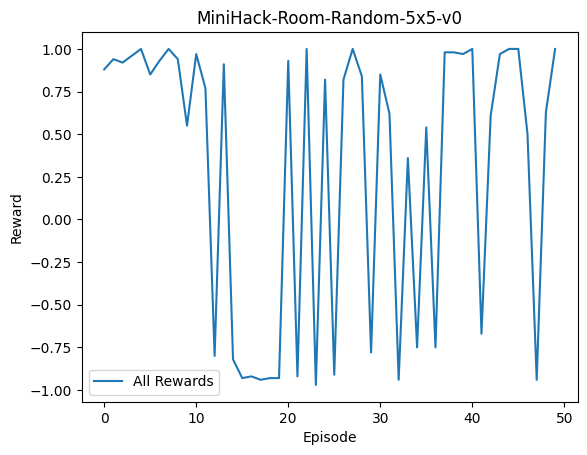

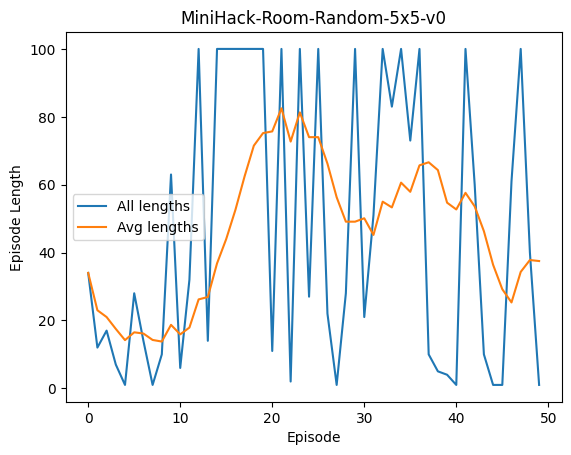

----- Starting MiniHack-Eat-v0 ----- 
episode: 1, reward: -2.44, average_reward: -2.44 total length: 250, average length: 250.0
episode: 2, reward: -2.29, average_reward: -2.365 total length: 250, average length: 250.0
episode: 3, reward: -2.34, average_reward: -2.356666666666667 total length: 250, average length: 250.0
episode: 4, reward: -2.25, average_reward: -2.33 total length: 250, average length: 250.0
episode: 5, reward: -2.37, average_reward: -2.338 total length: 250, average length: 250.0
episode: 6, reward: -2.23, average_reward: -2.3200000000000003 total length: 250, average length: 250.0
episode: 7, reward: -2.3, average_reward: -2.3171428571428576 total length: 250, average length: 250.0
episode: 8, reward: -2.2199999999999998, average_reward: -2.3049999999999997 total length: 250, average length: 250.0
episode: 9, reward: -2.31, average_reward: -2.3055555555555554 total length: 250, average length: 250.0
episode: 10, reward: -2.1799999999999997, average_reward: -2.2929999

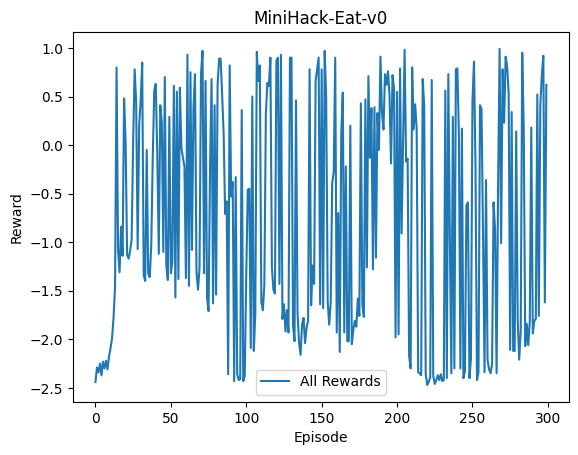

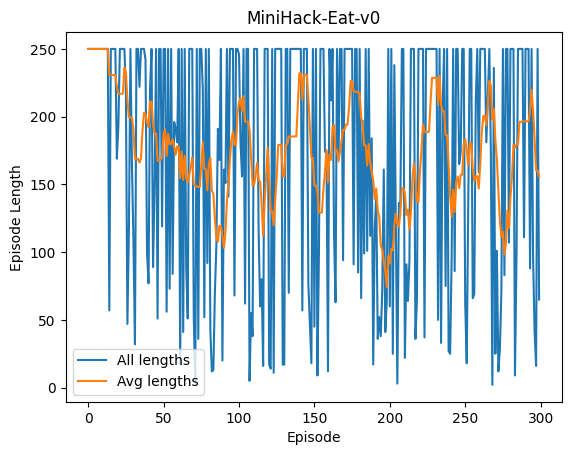

----- Starting MiniHack-LavaCross-Full-v0 ----- 
episode: 1, reward: -1.09, average_reward: -1.09 total length: 135, average length: 135.0
episode: 2, reward: -1.18, average_reward: -1.135 total length: 127, average length: 131.0
episode: 3, reward: -2.35, average_reward: -1.54 total length: 250, average length: 170.66666666666666
episode: 4, reward: -2.21, average_reward: -1.7075 total length: 250, average length: 190.5
episode: 5, reward: -2.16, average_reward: -1.798 total length: 250, average length: 202.4
episode: 6, reward: -2.27, average_reward: -1.8766666666666667 total length: 250, average length: 210.33333333333334
episode: 7, reward: -2.23, average_reward: -1.9271428571428573 total length: 250, average length: 216.0
episode: 8, reward: -1.7899999999999996, average_reward: -1.91 total length: 209, average length: 215.125
episode: 9, reward: -1.41, average_reward: -1.8544444444444441 total length: 178, average length: 211.0
episode: 10, reward: -2.01, average_reward: -1.869999

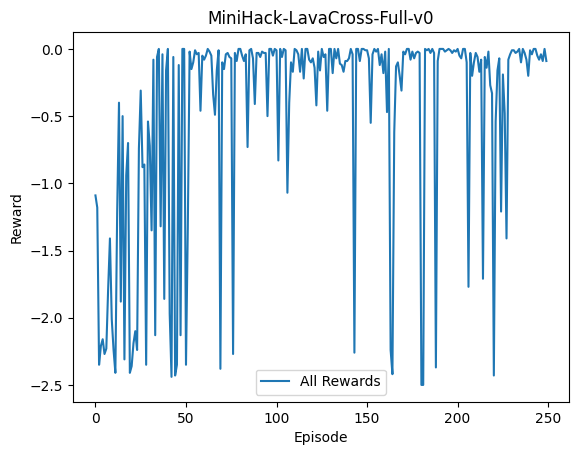

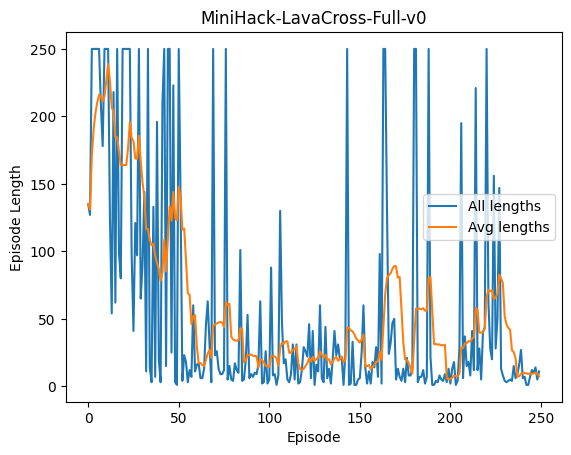

In [35]:
agent_2d = ActorCriticModel2D(len(ACTION_SPACE))
# agent_2d = agent_2d.cuda()

for env_obj in envs:
  print(f"{'-'*5} Starting {env_obj['name']} {'-'*5} ")

  env = gym.make(env_obj["name"], actions=env_obj["action_space"], observation_keys=("glyphs", "chars", "colors", "pixel", "message", 'glyphs_crop'))
  # self.env = WarpFrame(self.env)
  env = Glyp2DhWrapper(env)

  a2c = ActorCriticRun(action_space=env_obj["action_space"], env_name=env_obj["name"], model=agent_2d, env=env, max_episodes=env_obj["episodes"], must_print=env_obj["must_print"])
  a2c.run()
  a2c.plot_results()

  torch.save(agent_2d.state_dict(), "/content/drive/MyDrive/University/Honours/RLWeights/a2c_2d_weights.pth")

----- Starting MiniHack-Quest-Easy-v0 ----- 


<ipython-input-28-dfb5483ff5ae>:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_softmax_dist = torch_func.softmax(policy_dist)


episode: 1, reward: -0.8799999999999999, average_reward: -0.8799999999999999 total length: 112, average length: 112.0
episode: 2, reward: -0.22999999999999998, average_reward: -0.5549999999999999 total length: 25, average length: 68.5
episode: 3, reward: -4.58, average_reward: -1.8966666666666665 total length: 500, average length: 212.33333333333334
episode: 4, reward: -0.55, average_reward: -1.5599999999999998 total length: 63, average length: 175.0
episode: 5, reward: -0.8099999999999998, average_reward: -1.4099999999999997 total length: 88, average length: 157.6
episode: 6, reward: -0.5800000000000001, average_reward: -1.2716666666666665 total length: 61, average length: 141.5
episode: 7, reward: -0.6599999999999999, average_reward: -1.1842857142857142 total length: 74, average length: 131.85714285714286
episode: 8, reward: -1.2500000000000002, average_reward: -1.1925 total length: 133, average length: 132.0
episode: 9, reward: -2.1199999999999997, average_reward: -1.295555555555555

/usr/local/lib/python3.10/dist-packages/nle/env/base.py:602: UserWarning: Warning: smooth quitting of game failed, aborting.
  warnings.warn("Warning: smooth quitting of game failed, aborting.")


episode: 39, reward: -4.779999999999999, average_reward: -1.203076923076923 total length: 500, average length: 110.0
episode: 40, reward: -1.8999999999999997, average_reward: -1.2205 total length: 215, average length: 125.8
episode: 41, reward: 0.0, average_reward: -1.190731707317073 total length: 2, average length: 114.2
episode: 42, reward: -0.17000000000000004, average_reward: -1.1664285714285714 total length: 22, average length: 109.3
episode: 43, reward: -0.5700000000000001, average_reward: -1.1525581395348836 total length: 60, average length: 112.7
episode: 44, reward: -0.74, average_reward: -1.143181818181818 total length: 82, average length: 120.4
episode: 45, reward: -0.26, average_reward: -1.1235555555555554 total length: 29, average length: 121.1
episode: 46, reward: -0.6799999999999999, average_reward: -1.1139130434782607 total length: 73, average length: 118.0
episode: 47, reward: -0.19, average_reward: -1.094255319148936 total length: 25, average length: 115.5
episode: 48

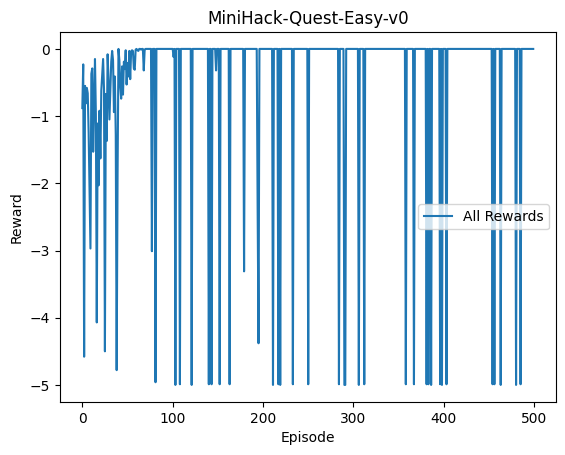

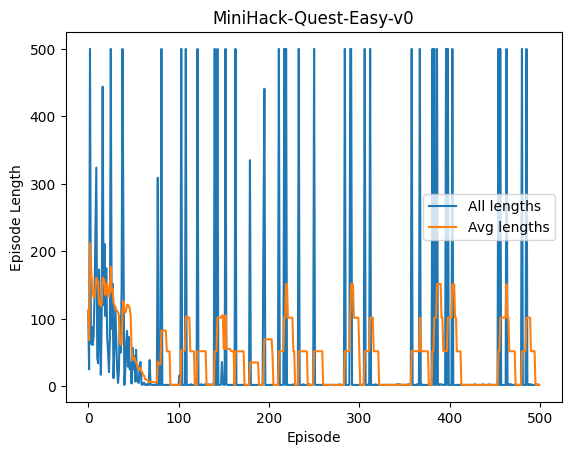

----- Starting MiniHack-Quest-Medium-v0 ----- 
episode: 1, reward: -5.39, average_reward: -5.39 total length: 578, average length: 578.0
episode: 2, reward: -4.169999999999999, average_reward: -4.779999999999999 total length: 449, average length: 513.5
episode: 3, reward: -2.09, average_reward: -3.883333333333333 total length: 236, average length: 421.0
episode: 4, reward: -4.06, average_reward: -3.9274999999999993 total length: 434, average length: 424.25
episode: 5, reward: -2.51, average_reward: -3.6439999999999997 total length: 280, average length: 395.4
episode: 6, reward: -1.71, average_reward: -3.3216666666666668 total length: 188, average length: 360.8333333333333
episode: 7, reward: -6.569999999999999, average_reward: -3.7857142857142856 total length: 701, average length: 409.42857142857144
episode: 8, reward: -2.81, average_reward: -3.6637499999999994 total length: 305, average length: 396.375
episode: 9, reward: -2.87, average_reward: -3.575555555555555 total length: 318, av

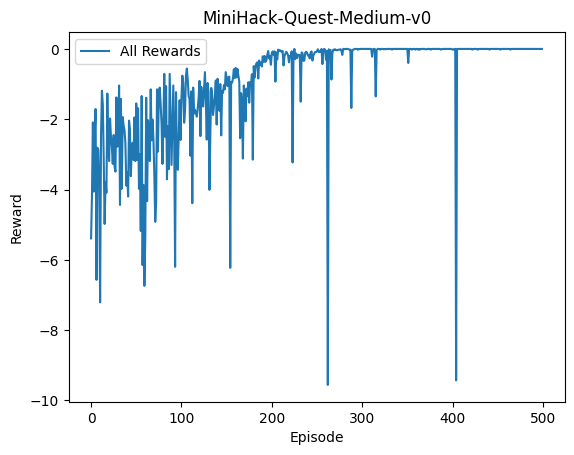

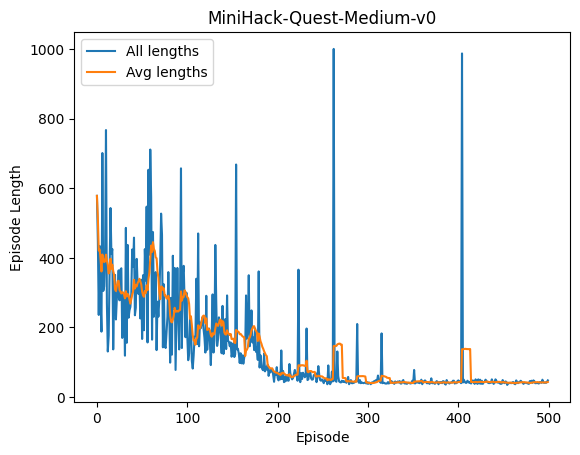

----- Starting iniHack-Quest-Hard-v0 ----- 


NameNotFound: ignored

In [38]:
for env_obj in quest_envs:
  print(f"{'-'*5} Starting {env_obj['name']} {'-'*5} ")
  agent_quest = ActorCriticModel2D(len(ACTION_SPACE))
  # agent_quest = agent_quest.cuda()

  env = gym.make(env_obj["name"], actions=env_obj["action_space"], observation_keys=("glyphs", "chars", "colors", "pixel", "message", 'glyphs_crop'))
  # self.env = WarpFrame(self.env)
  env = Glyp2DhWrapper(env)

  # agent_2d.set_action_space(env_obj["action_space"])
  a2c = ActorCriticRun(action_space=env_obj["action_space"], env_name=env_obj["name"], model=agent_quest, env=env, max_episodes=env_obj["episodes"], must_print=env_obj["must_print"])
  a2c.run()
  a2c.plot_results()

  torch.save(agent_2d.state_dict(), "/content/drive/MyDrive/University/Honours/RLWeights/a2c_quest_weights.pth")

In [ ]:
average_rwrds = []
for i in range(5):
  for env_obj in quest_envs:
    print(f"{'-'*5} Starting {env_obj['name']} {'-'*5} ")
    agent_quest = ActorCriticModel2D(len(ACTION_SPACE))
    # agent_quest = agent_quest.cuda()

    env = gym.make(env_obj["name"], actions=env_obj["action_space"], observation_keys=("glyphs", "chars", "colors", "pixel", "message", 'glyphs_crop'))
    # self.env = WarpFrame(self.env)
    env = Glyp2DhWrapper(env)

    # agent_2d.set_action_space(env_obj["action_space"])
    a2c = ActorCriticRun(action_space=env_obj["action_space"], env_name=env_obj["name"], model=agent_quest, env=env, max_episodes=env_obj["episodes"], must_print=env_obj["must_print"])
    a2c.run()
    rwrd = a2c.all_rewards
    average_rwrds.append(rwrd)
    a2c.plot_results()

    torch.save(agent_quest.state_dict(), "/content/drive/MyDrive/University/Honours/RLWeights/a2c_quest_hard_weights.pth")

----- Starting MiniHack-Quest-Hard-v0 ----- 


<ipython-input-28-dfb5483ff5ae>:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_softmax_dist = torch_func.softmax(policy_dist)


episode: 1, reward: -9.48, average_reward: -9.48 total length: 1000, average length: 1000.0
episode: 2, reward: -8.549999999999999, average_reward: -9.015 total length: 892, average length: 946.0
episode: 3, reward: -9.6, average_reward: -9.21 total length: 1000, average length: 964.0
episode: 4, reward: -9.66, average_reward: -9.322500000000002 total length: 1000, average length: 973.0
episode: 5, reward: -9.46, average_reward: -9.350000000000001 total length: 1000, average length: 978.4
episode: 6, reward: -9.61, average_reward: -9.393333333333334 total length: 1000, average length: 982.0
episode: 7, reward: -9.51, average_reward: -9.41 total length: 1000, average length: 984.5714285714286
episode: 8, reward: -9.5, average_reward: -9.42125 total length: 1000, average length: 986.5
episode: 9, reward: -9.579999999999998, average_reward: -9.43888888888889 total length: 1000, average length: 988.0
episode: 10, reward: -9.41, average_reward: -9.436 total length: 1000, average length: 989

/usr/local/lib/python3.10/dist-packages/nle/env/base.py:602: UserWarning: Warning: smooth quitting of game failed, aborting.
  warnings.warn("Warning: smooth quitting of game failed, aborting.")


episode: 12, reward: -9.54, average_reward: -9.455833333333333 total length: 1000, average length: 1000.0
episode: 13, reward: -9.509999999999998, average_reward: -9.459999999999999 total length: 1000, average length: 1000.0
episode: 14, reward: -9.57, average_reward: -9.467857142857142 total length: 1000, average length: 1000.0
episode: 15, reward: -9.44, average_reward: -9.466 total length: 1000, average length: 1000.0
episode: 16, reward: -9.45, average_reward: -9.465 total length: 1000, average length: 1000.0
episode: 17, reward: -9.46, average_reward: -9.464705882352941 total length: 1000, average length: 1000.0
episode: 18, reward: -9.59, average_reward: -9.471666666666668 total length: 1000, average length: 1000.0
episode: 19, reward: -9.399999999999999, average_reward: -9.467894736842107 total length: 1000, average length: 1000.0
episode: 20, reward: -9.489999999999998, average_reward: -9.469000000000001 total length: 1000, average length: 1000.0
episode: 21, reward: -9.33, ave